In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

In [2]:
data = pd.read_csv("C:/Users/Akif/Desktop/football/data_10years.csv")
data.shape

(3614, 16)

In [3]:
target_columns = ['result']
feature_columns = ['own_goals', 'own_position', 'opponent_goals', 'opponent_position', 'home_total_market_value', 'home_key_players', 'away_total_market_value', 'away_key_players', 'home_position_to_goal', 'away_position_to_goal', 'home_win_h2h', 'home_home_win', 'away_away_win', 'home_last_5_game_win', 'away_last_5_game_win']

In [4]:
X = data[feature_columns].values
y = data[target_columns].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 2312
Validation set size: 579
Testing set size: 723


In [5]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32),
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='hyperband',
                     project_name='football_model')


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


tuner.search(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[stop_early])


best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


model = tuner.hypermodel.build(best_hps)


history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=2)

Reloading Tuner from hyperband\football_model\tuner0.json
Epoch 1/50


C:\Users\Akif\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 - 2s - 62ms/step - accuracy: 0.8676 - loss: 0.3823 - val_accuracy: 0.9603 - val_loss: 0.1573
Epoch 2/50
37/37 - 0s - 5ms/step - accuracy: 0.9775 - loss: 0.0659 - val_accuracy: 0.9983 - val_loss: 0.0187
Epoch 3/50
37/37 - 0s - 5ms/step - accuracy: 0.9801 - loss: 0.0525 - val_accuracy: 1.0000 - val_loss: 0.0120
Epoch 4/50
37/37 - 0s - 6ms/step - accuracy: 0.9879 - loss: 0.0338 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/50
37/37 - 0s - 5ms/step - accuracy: 0.9732 - loss: 0.0724 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 6/50
37/37 - 0s - 5ms/step - accuracy: 0.9693 - loss: 0.0836 - val_accuracy: 0.9983 - val_loss: 0.0036
Epoch 7/50
37/37 - 0s - 5ms/step - accuracy: 0.9693 - loss: 0.1034 - val_accuracy: 0.9965 - val_loss: 0.0162
Epoch 8/50
37/37 - 0s - 5ms/step - accuracy: 0.9667 - loss: 0.1164 - val_accuracy: 0.9965 - val_loss: 0.0100
Epoch 9/50
37/37 - 0s - 5ms/step - accuracy: 0.9888 - loss: 0.0656 - val_accuracy: 1.0000 - val_loss: 5.2588e-04
Epoch 10/50
37/37 - 0s - 

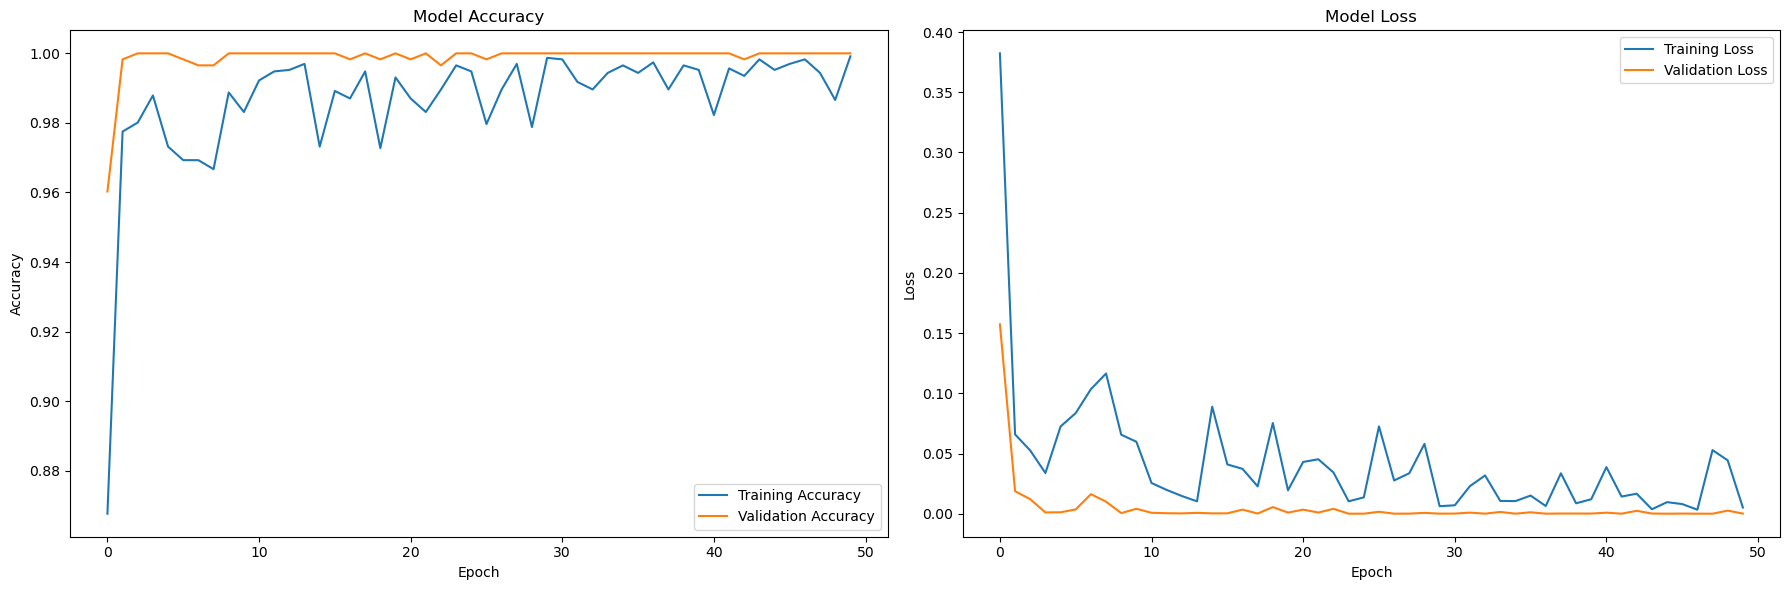

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')


axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')


plt.tight_layout()
plt.show()

In [7]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3568e-04 
Test Loss: 0.00014357517648022622
Test Accuracy: 1.0


In [9]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:
[[177   0   0]
 [  0 337   0]
 [  0   0 209]]
